In [4]:
#Ning
#17 Nov
#Metaheuristics TP5

#import statements
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
import random

In [5]:
#preliminary look at the X.dat file and Y.dat file
#Note that 0 corresponds to 'two' and 1 corresponds to 'three'

def transfer_file_to_arrays (filename):
    
    images = []
    
    with open(filename, "r") as fp:
        for line in fp:
            line = line.split(",") #split values on ,
            for i in range(0, len(line)):
                line[i] = float(line[i]) #turn into a float
            line = np.array(line)
            images.append(line) #append in np array format

    return images

def get_labels (filename):
    labels = []
    with open(filename, "r") as fp:
        for line in fp:
            labels.append(float(line))
    return labels

In [6]:
images = transfer_file_to_arrays("X.dat")
print(len(images)) #confirm that we have 200 images stored
print(images[0].shape[0]) #confirm the shape of the image
labels = get_labels("Y.dat")
print(len(labels))

200
400
200


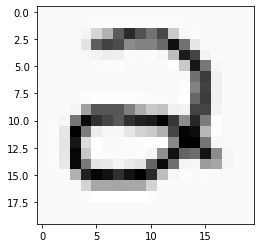

In [7]:
#show a sample of the image to see if we have one
plt.imshow(np.reshape(images[2], (20,20), order="F"), cmap="Greys")

In [8]:
def turn_two_to_one (theta1, theta2):
    return np.concatenate((theta1.flatten(), theta2.flatten()), axis=None)

def turn_one_to_two (big_theta):
    
    theta1 = np.reshape(big_theta[0:10025], (25,401)) #need to be careful here because of shape
    theta2 = np.reshape(big_theta[10025:], (1,26))
    
    return theta1, theta2

In [9]:
#testing
a = np.zeros((25,401))
b = np.full((1,26),1)

ab = turn_two_to_one(a,b)
c,d = turn_one_to_two(ab)

print(a==c)
print(b==d)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]]


In [10]:
def sigmoid (X):
    return 1/(1+np.exp(-X))

def first_layer (picture):
    '''
    first layer's role is to download the 400 pixels of the picture
    and have one neuron that is the bias 
    '''
    #add bias neuron
    layer_n = picture.shape[0]
    first_layer = np.insert(picture, 0, 1.0) #add 1 as the bias
    
    return first_layer

def second_layer (layer, theta):
    '''
    second layer contains 25 neurons, plus 1 for the bias
    job is to matmul the first layer's output with theta, apply sigmoid function, add bias
    
    theta is the matrix of size (25, 401)
    '''
    
    res = np.matmul(theta, layer) #should be a matmul of sizes (25,401)(401,) -> (25,)
    
    #apply the sigmoid function
    res = sigmoid(res)
    
    res_n = res.shape[0] #should be 25
    
    second_layer = np.insert(res, 0, 1.0) #add 1 as the bias
    
    return second_layer

def third_layer (layer, theta):
    '''
    third layer contains 1 neuron
    job is to matmul the second layer's output with theta, apply sigmoid function, and return
    
    theta is the matrix of size (1, 26)
    '''
    
    res = np.matmul(theta, layer) #should be a matmul of sizes (1,26)(26,) -> (1,)
    
    #apply the sigmoid function
    res = sigmoid(res)
    
    return res #should be a singular value answer, our prediction

def nn_predict (image, big_theta):
    '''
    application of all three layers
    '''
    
    #temporary values
    theta1, theta2 = turn_one_to_two(big_theta)
    
    layer1 = first_layer(image)
    layer2 = second_layer(layer1, theta1) #this theta value will take on PSO's output once complete
    layer3 = third_layer(layer2, theta2)
    
    return layer3[0] #the prediction    

In [11]:
#do some testing with values, we should be able to get a value
test = images[100]
print(nn_predict(test, ab))

0.999998629042793


Well, that certainly looks like a value. Good job kense. Time to start PSO

In [12]:
def calc_fitness(big_theta, images, labels):
    fitness = 0.0
    for k in range(0, len(labels)):
        fitness+=(labels[k] - nn_predict(images[k], big_theta))**2
    return fitness/len(labels)

In [13]:
t1 = np.random.rand(25,401)
t2 = np.random.rand(1,26)
bt = turn_two_to_one(t1,t2)
print(calc_fitness(bt, images, labels))

0.4999969692277524


In [63]:
def init_positions ():
    return 2*np.random.rand(25,401)-1, 2*np.random.rand(1,26)-1

def init_velocities ():
    return np.zeros((25,401)), np.zeros((1,26))

In [133]:
def PSO (n, tmax, images, labels):
    
    #variables
    global_best = [None,float('inf')] #global_best is (position, fitness)
    inertia_constant = 0.9
    c1 = 1.99811 #defined by the assignment as close to 2
    c2 = 1.99899
    t = 0
    vmax = 0.05
    
    #initialize particles -> (s, v, b)
    particles = []
    for i in range(n):
        s0_a, s0_b = init_positions()
        v0_a, v0_b = init_velocities()
        
        big_s0 = turn_two_to_one(s0_a, s0_b)
        big_v0 = turn_two_to_one(v0_a, v0_b)
        particle = [big_s0, big_v0, big_s0] #personal_best init is s0
        particles.append(particle)
   
    
    while(t < tmax):
        
        #for each particle
        for i in range(n):
            fit = calc_fitness(particles[i][0], images, labels) #positions are taken to calc fitness
            pbest_fit = calc_fitness(particles[i][2], images, labels)
            if fit <= pbest_fit: #if better than personal_best
                particles[i][2] = particles[i][0][:] #copy as new best
        
        #set global_best
        for i in range(n):
            fit = calc_fitness(particles[i][2], images, labels)
            if fit <= global_best[1]: #if personal_best better than global_best
                global_best[1] = fit
                global_best[0] = particles[i][2][:] #set new values for global
        
        #for each particle, update s and v
        for i in range(n):
            r1 = random.random()
            r2 = random.random()
            
            #for each particle, update its particles...
            for x in range(len(particles[i][1])): #update each particle's v
                particles[i][1][x] = (inertia_constant*particles[i][1][x]) + (c1*r1*(particles[i][2][x]-particles[i][0][x])) + (c2*r2*(global_best[0][x]-particles[i][0][x]))
                
                #velocity cutoff?
                if abs(particles[i][1][x]) >= vmax:
                    particles[i][1][x] = vmax*np.sign(particles[i][1][x])
            
            #particles[i][0] = np.add(particles[i][0],particles[i][1]) #then update s
            for x in range(len(particles[i][0])):
                particles[i][0][x] = particles[i][0][x] + particles[i][1][x]
                
                #correct if particle is out of the problem range
                if particles[i][0][x] > 1:
                    particles[i][0][x] = particles[i][0][x]-(2*(particles[i][0][x]- 1))
                elif particles[i][0][x] < -1:
                    particles[i][0][x] = particles[i][0][x] + (2*(-1-particles[i][0][x]))
                
        
        t = t + 1
    
    #get the stats of the global_best
    theta1, theta2 = turn_one_to_two(global_best[0]) #separate global_best's particle into thetas
    return theta1, theta2 #return

In [134]:
#testing
a,b = PSO(5, 20, images, labels)

print(a,b)

[[ 0.04141911 -0.53643061  0.02575446 ...  0.05496644 -0.48273897
   0.27185117]
 [-0.03324281  0.13415471 -0.64018736 ...  0.12325364 -0.23436656
  -0.13798685]
 [-0.130798   -0.06523637 -0.42358662 ... -0.06189853  0.00363489
  -0.17208476]
 ...
 [ 0.26782552  0.67201824  0.06562993 ... -0.0610091   0.2340046
   0.08098528]
 [ 0.17860071 -0.62324057  0.84422582 ... -0.56425406 -0.23664832
  -0.98791353]
 [-0.12413034  0.5171035   0.03157963 ...  0.15973427  0.35942485
   0.09072313]] [[ 0.55477047 -0.43116453 -0.23016835  0.08320026  0.97803995 -0.99294717
   0.13626557  0.36809108 -0.17642579 -0.07138712 -0.25219757  0.11077588
   0.28401625 -0.48052093 -0.11882789  0.96642528 -0.38514145  0.06427776
  -0.24786217  0.12248093  0.08128845  0.42933466 -0.50702913 -0.34998308
   0.49468392 -0.09460695]]


In [135]:
#error testing
correct = 0
predictions = []
for i in range(len(images)):
    predict = nn_predict(images[i], turn_two_to_one(a,b))
    predictions.append(predict)
    truth = labels[i]
    
    if truth == int(predict+0.5):
        correct += 1
print(correct/len(labels))

0.715


In [136]:
predictions

[0.7941702321140182,
 0.5496741286567786,
 0.6347881811581434,
 0.5349793807406592,
 0.7533565427346098,
 0.42890487021680307,
 0.7805369590005011,
 0.686055543110346,
 0.7678923215089899,
 0.7415807339492052,
 0.7899601314895636,
 0.6889975794604275,
 0.6055071250017511,
 0.44757207313709857,
 0.7232879212114776,
 0.6470529489481702,
 0.7464773182670105,
 0.4222960678905817,
 0.7318695812558157,
 0.6388449959119994,
 0.7072660073970587,
 0.7565331294908266,
 0.6239371630988294,
 0.7214813315938545,
 0.5366718452722409,
 0.49409167073405696,
 0.5693773717647526,
 0.6709575954574932,
 0.6898721363844141,
 0.867003697108024,
 0.46644563771210457,
 0.8077022241169072,
 0.7577601109381138,
 0.6606331878060685,
 0.5528599490757657,
 0.8004928415861932,
 0.5074331226917808,
 0.7986568037604634,
 0.46870492536452885,
 0.534631857952044,
 0.7644832515110833,
 0.7092792831127741,
 0.70829256125848,
 0.7377550960886142,
 0.6955197568378562,
 0.6609570362608779,
 0.6541820307186983,
 0.5843130749